In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import networkx as nx
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from shapely import wkt
from scipy.spatial import distance

In [2]:
flows = pd.read_csv('data.csv')

In [3]:
flows['jobs'] = flows['jobs'] - 0.1
total_jobs = flows['jobs'].sum()
print(total_jobs)

376833285.0


In [4]:
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(np.sqrt(res.mean()), 3)
    
    return RMSE

In [5]:
flows['log_dest_jobs'] = np.log(flows['jobs'] + .001)

eq_form_1 = 'flows ~ station_origin + log_dest_jobs + log_distance-1'
sim = smf.glm(formula = eq_form_1, data = flows, family=sm.families.Poisson()).fit()

print(sim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Mon, 29 Apr 2024   Deviance:                   1.8615e+06
Time:                        05:38:20   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [6]:
def update_newjob(row):
    if 'Canary Wharf' in row['station_destination']:
        return row['jobs'] / 2
    else:
        return row['jobs']

flows['newjob'] = flows.apply(update_newjob, axis=1)

In [7]:
flows['log_dest_jobs_new'] = np.log(flows['newjob'] + .001)
eq_form_2 = 'flows ~ station_origin + log_dest_jobs_new + log_distance-1'
sim_new = smf.glm(formula=eq_form_2, data=flows, family=sm.families.Poisson()).fit()
print(sim_new.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0267e+06
Date:                Mon, 29 Apr 2024   Deviance:                   1.8812e+06
Time:                        05:38:34   Pearson chi2:                 2.88e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [8]:
old_coef = sim.params[sim.params.index.str.startswith('station_origin')]
new_coef = sim_new.params[sim_new.params.index.str.startswith('station_origin')]

changed_stations = pd.DataFrame({
    'station': old_coef.index,
    'old_coef': old_coef.values,
    'new_coef': new_coef.values
})

changed_stations['percent_change'] = ((changed_stations['new_coef'] - changed_stations['old_coef']) / changed_stations['old_coef']) * 100
print(changed_stations)


                              station  old_coef  new_coef  percent_change
0          station_origin[Abbey Road]  3.250629  3.228900       -0.668445
1       station_origin[Acton Central]  5.017300  4.954986       -1.241993
2          station_origin[Acton Town]  4.563297  4.505182       -1.273521
3             station_origin[Aldgate]  3.324153  3.263312       -1.830282
4        station_origin[Aldgate East]  3.458046  3.399918       -1.680943
..                                ...       ...       ...             ...
393       station_origin[Wood Street]  5.242424  5.175776       -1.271326
394          station_origin[Woodford]  5.161061  5.108690       -1.014719
395   station_origin[Woodgrange Park]  5.255062  5.196918       -1.106449
396     station_origin[Woodside Park]  4.699052  4.641170       -1.231781
397  station_origin[Woolwich Arsenal]  6.905989  6.916373        0.150366

[398 rows x 4 columns]


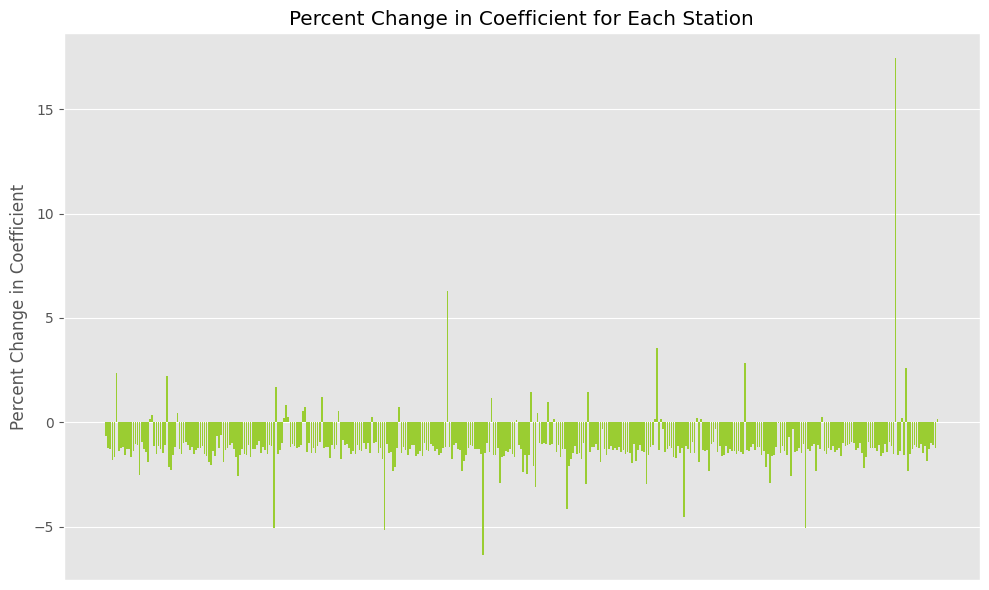

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.bar(changed_stations['station'], changed_stations['percent_change'], color='yellowgreen')
plt.ylabel('Percent Change in Coefficient')
plt.title('Percent Change in Coefficient for Each Station')
plt.xticks([])
plt.tight_layout()
plt.show()


In [10]:
sorted_changes = changed_stations.sort_values(by='percent_change', ascending=False)
top_10_changes = sorted_changes.head(10)
print(top_10_changes)


                             station  old_coef  new_coef  percent_change
377  station_origin[West India Quay]  1.184739  1.391539       17.455369
163      station_origin[Heron Quays]  3.734459  3.968836        6.276076
263           station_origin[Poplar]  4.119542  4.266556        3.568703
305       station_origin[South Quay]  4.147878  4.264868        2.820476
382        station_origin[Westferry]  4.312771  4.425456        2.612802
5         station_origin[All Saints]  3.380981  3.461319        2.376162
29         station_origin[Blackwall]  3.609648  3.689761        2.219420
81      station_origin[Crossharbour]  4.336149  4.410379        1.711896
230         station_origin[Mudchute]  4.228312  4.289648        1.450593
203     station_origin[Langdon Park]  4.218719  4.279849        1.449018


##### Flows Change

In [31]:
flows['new_flows'] = sim_new.predict(flows)
flows['flow_change'] = flows['new_flows'] - flows['flows']
station_flow_changes = flows.groupby('station_origin')['flow_change'].sum().reset_index()
print("Flow changes for each station_origin:")
print(station_flow_changes)

Flow changes for each station_origin:
       station_origin   flow_change
0          Abbey Road -2.813749e-11
1       Acton Central -2.305705e-10
2          Acton Town -1.392051e-10
3             Aldgate  4.207582e-10
4        Aldgate East -1.583418e-10
..                ...           ...
393       Wood Street -2.726352e-11
394          Woodford -3.217870e-11
395   Woodgrange Park -3.898037e-11
396     Woodside Park -6.599787e-11
397  Woolwich Arsenal -7.153744e-11

[398 rows x 2 columns]


In [32]:
print("Flows and Predicted Flows:")
print(flows[['flows', 'new_flows','station_origin']])

Flows and Predicted Flows:
       flows   new_flows    station_origin
0          0   58.285945        Abbey Road
1          1    1.012064        Abbey Road
2          3    2.832766        Abbey Road
3          1   41.061004        Abbey Road
4         37   51.389876        Abbey Road
...      ...         ...               ...
61408    127  130.132945  Woolwich Arsenal
61409    608  279.076226  Woolwich Arsenal
61410      6   33.859509  Woolwich Arsenal
61411     81  104.643758  Woolwich Arsenal
61412     76   78.813093  Woolwich Arsenal

[61413 rows x 3 columns]


In [33]:
sorted_changes = station_flow_changes.sort_values(by='flow_change', ascending=False)
top_10_changes = sorted_changes.head(10)
print(top_10_changes)

        station_origin   flow_change
109  Elephant & Castle  4.365917e-10
3              Aldgate  4.207582e-10
293    Shepherd's Bush  2.837357e-10
131      Golders Green  7.633538e-11
352         Upton Park  6.966783e-11
28     Blackhorse Road  6.903100e-11
59     Carpenders Park  5.340439e-11
166       Highams Park  5.071676e-11
27         Blackfriars  3.362910e-11
256         Penge West  3.159784e-11


In [38]:
# 根据 'station_origin' 进行 groupby
grouped_flows = flows.groupby('station_destination')[['flows', 'new_flows']]

# 计算每个站点的汇总
summed_flows = grouped_flows.sum().reset_index()

print("Summed Flows and New Flows by Station Origin:")
print(summed_flows)

Summed Flows and New Flows by Station Origin:
    station_destination  flows    new_flows
0            Abbey Road    345   458.251539
1         Acton Central    750   388.163353
2            Acton Town   2202  2158.518323
3               Aldgate   7782  8818.696199
4          Aldgate East   7932  9381.131750
..                  ...    ...          ...
393         Wood Street    404   333.070604
394            Woodford    706   659.949271
395     Woodgrange Park    242   152.128216
396       Woodside Park    745   603.717178
397    Woolwich Arsenal   4428  1073.767763

[398 rows x 3 columns]


In [39]:
summed_flows['flow_change'] = (summed_flows['new_flows'] - summed_flows['flows'])
largest_flow_changes = summed_flows.nlargest(10, 'flow_change')

print("Top 10 flow changes for each station_origin:")
print(summed_flows[['station_destination', 'flow_change']])

Top 10 flow changes for each station_origin:
    station_destination  flow_change
0            Abbey Road   113.251539
1         Acton Central  -361.836647
2            Acton Town   -43.481677
3               Aldgate  1036.696199
4          Aldgate East  1449.131750
..                  ...          ...
393         Wood Street   -70.929396
394            Woodford   -46.050729
395     Woodgrange Park   -89.871784
396       Woodside Park  -141.282822
397    Woolwich Arsenal -3354.232237

[398 rows x 2 columns]


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_flows, x='station_origin', y='flow_change', color='b')
plt.xlabel('Station Origin')
plt.ylabel('Flow Change')
plt.title('Flow Changes by Station Origin')
plt.xticks([])
plt.tight_layout()
plt.show()


TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.groupby.generic.DataFrameGroupBy'>.

<Figure size 1200x600 with 0 Axes>